In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import os
import shutil

# Define the source and destination directories for each class
waste_train_dir = '/kaggle/input/waste-classification-data/DATASET/TRAIN'
waste_test_dir = '/kaggle/input/waste-classification-data/DATASET/TEST'
unknown_train_dir = '/kaggle/input/random-images/dataset/train'
unknown_test_dir = '/kaggle/input/random-images/dataset/test'

# Define the combined directory path under /kaggle/working/
combined_train_dir = '/kaggle/working/combined-dataset/TRAIN'
combined_test_dir = '/kaggle/working/combined-dataset/TEST'

# Create the combined directory structure if it doesn't exist
os.makedirs(os.path.join(combined_train_dir, 'O'), exist_ok=True)
os.makedirs(os.path.join(combined_train_dir, 'R'), exist_ok=True)
os.makedirs(os.path.join(combined_train_dir, 'U'), exist_ok=True)

os.makedirs(os.path.join(combined_test_dir, 'O'), exist_ok=True)
os.makedirs(os.path.join(combined_test_dir, 'R'), exist_ok=True)
os.makedirs(os.path.join(combined_test_dir, 'U'), exist_ok=True)

# Copy Organic images from waste dataset to combined dataset (train and test)
def copy_images(src_dir, dest_dir, class_name):
    # Create the destination folder if it doesn't exist
    os.makedirs(os.path.join(dest_dir, class_name), exist_ok=True)
    
    # Get all image files from the source directory
    images = os.listdir(src_dir)
    
    for image in images:
        # Define the source and destination file paths
        src_file = os.path.join(src_dir, image)
        dest_file = os.path.join(dest_dir, class_name, image)
        
        # Copy the image to the new directory
        shutil.copy(src_file, dest_file)

# Copy Organic and Recyclable images from waste dataset
copy_images(os.path.join(waste_train_dir, 'O'), combined_train_dir, 'O')
copy_images(os.path.join(waste_train_dir, 'R'), combined_train_dir, 'R')
copy_images(os.path.join(waste_test_dir, 'O'), combined_test_dir, 'O')
copy_images(os.path.join(waste_test_dir, 'R'), combined_test_dir, 'R')

# Copy Unknown images from the unknown dataset
copy_images(unknown_train_dir, combined_train_dir, 'U')
copy_images(unknown_test_dir, combined_test_dir, 'U')

print("Images have been successfully integrated into the combined dataset located in '/kaggle/working/combined-dataset/'.")


Images have been successfully integrated into the combined dataset located in '/kaggle/working/combined-dataset/'.


In [4]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size and batch size
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Define directories for the combined dataset in the '/kaggle/working' directory
train_dir = '/kaggle/working/combined-dataset/TRAIN/'
test_dir = '/kaggle/working/combined-dataset/TEST/'

# Data generators for training and testing
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Load the ResNet50 base model without the top layer (include_top=False)
base_model_resnet50 = ResNet50(
    include_top=False,
    weights=None,  # Set to None, as we will manually load the weights
    input_shape=(224, 224, 3)
)

# Load the pre-trained weights from the specified location
weights_path = '/kaggle/input/waste-classification/keras/default/1/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model_resnet50.load_weights(weights_path)

# Freeze the layers of the base model to avoid training them
base_model_resnet50.trainable = False

# Build the model
model_resnet50 = Sequential([
    base_model_resnet50,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 classes: Organic, Recyclable, Unknown
])

# Compile the model
model_resnet50.compile(optimizer=Adam(learning_rate=0.0001), 
                       loss='categorical_crossentropy', 
                       metrics=['accuracy'])

# Set up a checkpoint to save the best model
checkpoint = ModelCheckpoint(
    '/kaggle/working/best_model_resnet50.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Train the model
history_resnet50 = model_resnet50.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE,
    callbacks=[checkpoint]
)

# Save the final model
model_resnet50.save('/kaggle/working/final_model_resnet50.keras')


Found 29033 images belonging to 3 classes.
Found 6002 images belonging to 3 classes.
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734531649.030532     107 service.cc:145] XLA service 0x7f3928002710 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734531649.030608     107 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734531649.030612     107 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  2/907 ━━━━━━━━━━━━━━━━━━━━ 1:12 80ms/step - accuracy: 0.3828 - loss: 1.1547  

I0000 00:00:1734531656.350112     107 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


907/907 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.5048 - loss: 0.9880
Epoch 1: val_accuracy improved from -inf to 0.77189, saving model to /kaggle/working/best_model_resnet50.keras
907/907 ━━━━━━━━━━━━━━━━━━━━ 114s 111ms/step - accuracy: 0.5049 - loss: 0.9879 - val_accuracy: 0.7719 - val_loss: 0.7568
Epoch 2/10
  1/907 ━━━━━━━━━━━━━━━━━━━━ 1:10 78ms/step - accuracy: 0.6250 - loss: 0.8221

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy improved from 0.77189 to 0.88889, saving model to /kaggle/working/best_model_resnet50.keras
907/907 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6250 - loss: 0.8221 - val_accuracy: 0.8889 - val_loss: 0.7361
Epoch 3/10
907/907 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.6875 - loss: 0.7241
Epoch 3: val_accuracy did not improve from 0.88889
907/907 ━━━━━━━━━━━━━━━━━━━━ 100s 110ms/step - accuracy: 0.6876 - loss: 0.7241 - val_accuracy: 0.8103 - val_loss: 0.6111
Epoch 4/10
  1/907 ━━━━━━━━━━━━━━━━━━━━ 1:18 87ms/step - accuracy: 0.5938 - loss: 0.7828
Epoch 4: val_accuracy improved from 0.88889 to 0.94444, saving model to /kaggle/working/best_model_resnet50.keras
907/907 ━━━━━━━━━━━━━━━━━━━━ 1s 856us/step - accuracy: 0.5938 - loss: 0.7828 - val_accuracy: 0.9444 - val_loss: 0.5783
Epoch 5/10
907/907 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.7247 - loss: 0.6489
Epoch 5: val_accuracy did not improve from 0.94444
907/907 ━━━━━━━━━━━━━━━━━━━━ 100s 109ms/step - ac

Found 29033 images belonging to 3 classes.
Found 6002 images belonging to 3 classes.
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


907/907 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.4547 - loss: 1.0754
Epoch 1: val_accuracy improved from -inf to 0.76303, saving model to /kaggle/working/best_model_resnet50.keras
907/907 ━━━━━━━━━━━━━━━━━━━━ 318s 338ms/step - accuracy: 0.4547 - loss: 1.0753 - val_accuracy: 0.7630 - val_loss: 0.8409 - learning_rate: 1.0000e-04
Epoch 2/50
  1/907 ━━━━━━━━━━━━━━━━━━━━ 1:14 82ms/step - accuracy: 0.5938 - loss: 0.8368

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy improved from 0.76303 to 0.94444, saving model to /kaggle/working/best_model_resnet50.keras
907/907 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5938 - loss: 0.8368 - val_accuracy: 0.9444 - val_loss: 0.8681 - learning_rate: 1.0000e-04
Epoch 3/50
907/907 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.5895 - loss: 0.8750
Epoch 3: val_accuracy did not improve from 0.94444
907/907 ━━━━━━━━━━━━━━━━━━━━ 303s 332ms/step - accuracy: 0.5895 - loss: 0.8750 - val_accuracy: 0.8103 - val_loss: 0.6865 - learning_rate: 1.0000e-04
Epoch 4/50
  1/907 ━━━━━━━━━━━━━━━━━━━━ 1:21 90ms/step - accuracy: 0.5625 - loss: 0.8516
Epoch 4: val_accuracy did not improve from 0.94444
907/907 ━━━━━━━━━━━━━━━━━━━━ 0s 83us/step - accuracy: 0.5625 - loss: 0.8516 - val_accuracy: 0.9444 - val_loss: 0.6796 - learning_rate: 1.0000e-04
Epoch 5/50
907/907 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.6261 - loss: 0.8254
Epoch 5: val_accuracy did not improve from 0.94444
907/907 ━━━━━━━━━━━━━━━━━━━

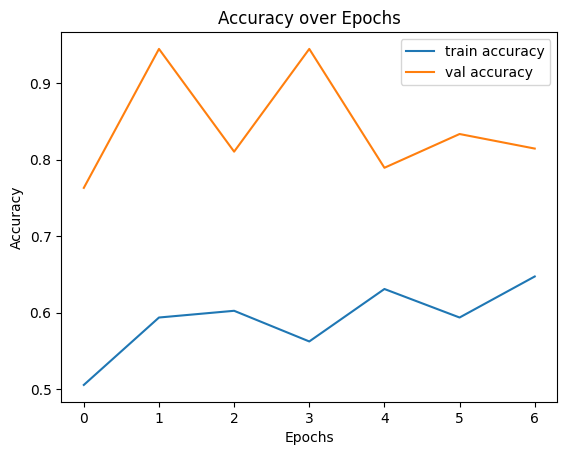

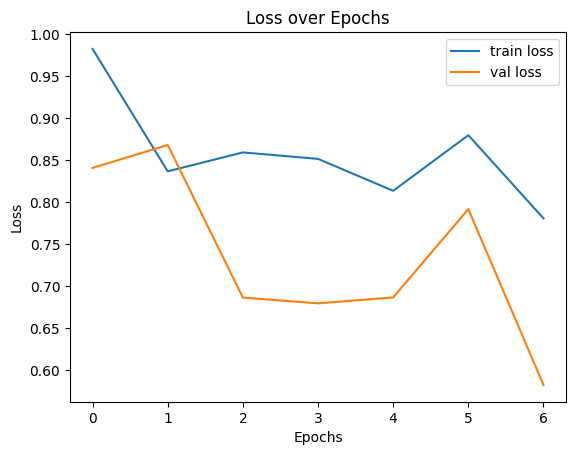

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set image dimensions and batch size
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Directories for training and validation datasets
train_dir = '/kaggle/working/combined-dataset/TRAIN/'
test_dir = '/kaggle/working/combined-dataset/TEST/'

# Define the data generators with data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,  # Increased rotation range
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# For validation, no augmentation, only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# Set up the generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # For multi-class classification
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Load the pre-trained ResNet50 model without the top layer (include_top=False)
base_model_resnet50 = ResNet50(
    include_top=False,
    weights=None,  # No weights from ImageNet, as you're using custom weights
    input_shape=(224, 224, 3)
)

# Load the custom weights
base_model_resnet50.load_weights('/kaggle/input/waste-classification/keras/default/1/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

# Freeze the layers of ResNet50 to prevent training them
base_model_resnet50.trainable = False

# Build the model
model_resnet50 = Sequential([
    base_model_resnet50,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),  # Dropout layer to prevent overfitting
    Dense(3, activation='softmax')  # 3 output classes
])

# Compile the model
model_resnet50.compile(optimizer=Adam(learning_rate=0.0001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# Callbacks to monitor training
checkpoint = ModelCheckpoint(
    '/kaggle/working/best_model_resnet50.keras',  # Save model in Keras format
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,  # Stop after 5 epochs of no improvement
    restore_best_weights=True  # Restore the best weights from earlier epochs
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Reduce learning rate by 50%
    patience=3,  # Wait for 3 epochs before reducing
    min_lr=1e-6  # Set a lower bound for the learning rate
)

# Train the model
history_resnet50 = model_resnet50.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=50,  # Increase epochs to 50 or more
    validation_data=test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

# Save the final model after training
model_resnet50.save('/kaggle/working/final_model_resnet50(1).keras')

# Optionally: Plot the accuracy and loss curves
import matplotlib.pyplot as plt

# Plot the training and validation accuracy
plt.plot(history_resnet50.history['accuracy'], label='train accuracy')
plt.plot(history_resnet50.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss
plt.plot(history_resnet50.history['loss'], label='train loss')
plt.plot(history_resnet50.history['val_loss'], label='val loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2

# Set image dimensions and batch size
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Directories for training and validation datasets
train_dir = '/kaggle/working/combined-dataset/TRAIN/'
test_dir = '/kaggle/working/combined-dataset/TEST/'

# Define the data generators with data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Set up the generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Load the pre-trained ResNet50 model without the top layer (include_top=False)
base_model_resnet50 = ResNet50(
    include_top=False,
    weights=None,
    input_shape=(224, 224, 3)
)

# Load custom weights
base_model_resnet50.load_weights('/kaggle/input/waste-classification/keras/default/1/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

# Unfreeze the last few layers of ResNet50
for layer in base_model_resnet50.layers[-10:]:
    layer.trainable = True

# Build the model
model_resnet50 = Sequential([
    base_model_resnet50,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compile the model
model_resnet50.compile(optimizer=Adam(learning_rate=0.0001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# Callbacks for model checkpoint, early stopping, and learning rate reduction
checkpoint = ModelCheckpoint(
    '/kaggle/working/best_model_resnet50.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

# Train the model
history_resnet50 = model_resnet50.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=50,
    validation_data=test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

# Save the final model
model_resnet50.save('/kaggle/working/final_model_resnet50(2).keras')


Found 29033 images belonging to 3 classes.
Found 6002 images belonging to 3 classes.
Epoch 1/50


I0000 00:00:1734534007.719822     107 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_26', 20 bytes spill stores, 20 bytes spill loads



907/907 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.8876 - loss: 6.1846
Epoch 1: val_accuracy improved from -inf to 0.94669, saving model to /kaggle/working/best_model_resnet50.keras
907/907 ━━━━━━━━━━━━━━━━━━━━ 398s 375ms/step - accuracy: 0.8876 - loss: 6.1825 - val_accuracy: 0.9467 - val_loss: 1.6326 - learning_rate: 1.0000e-04
Epoch 2/50
  1/907 ━━━━━━━━━━━━━━━━━━━━ 5:33 368ms/step - accuracy: 0.9688 - loss: 1.5553
Epoch 2: val_accuracy did not improve from 0.94669
907/907 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9688 - loss: 1.5553 - val_accuracy: 0.9444 - val_loss: 1.6491 - learning_rate: 1.0000e-04
Epoch 3/50
907/907 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.9428 - loss: 1.1641
Epoch 3: val_accuracy improved from 0.94669 to 0.95271, saving model to /kaggle/working/best_model_resnet50.keras
907/907 ━━━━━━━━━━━━━━━━━━━━ 318s 348ms/step - accuracy: 0.9428 - loss: 1.1638 - val_accuracy: 0.9527 - val_loss: 0.3922 - learning_rate: 1.0000e-04
Epoch 4/50
  1/907 ━━━━━━━